# PML Assignment 2

Dhairya Shah

R Yeeshu Dhurandhar

In [1]:
# imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from torchsummary import summary
import torch.nn as nn
from torch.optim import Adam
from matplotlib.animation import FuncAnimation

# Question 1
Find MLE estimate for parameters of a neural network for regression with Gaussian Homoskedastic noise, where noise variance has a fixed value = 0.0025. Your model summary should match with (1.2). Animate the MLE fit on the data along with the 95% noise variance intervals [2 marks]. What is the effect of varying the noise variance (only in model, not for regenerating the data) on the MLE fit, show it for 3 different noise variance values? [0.5 mark] Refer to this tutorial for building and training torch.nn models. Use FuncAnimation from matplotlib or Celluloid for animation.

In [2]:
num_datapoints = 100
np.random.seed(0)
X = torch.linspace(0, 1, num_datapoints)
noise = torch.distributions.Normal(0, 0.05).sample((num_datapoints,))
y = torch.sin(2 * np.pi * X) + noise

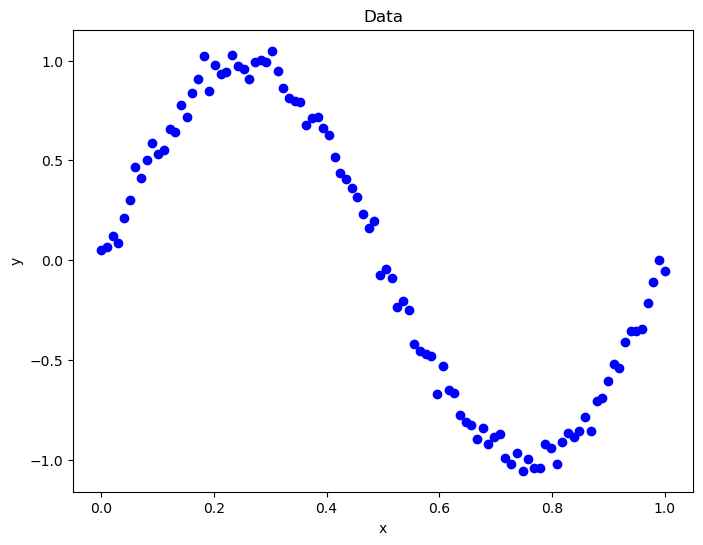

In [3]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
X_tensor = torch.Tensor(X).view(-1, 1)
y_tensor = torch.Tensor(y).view(-1, 1)

In [5]:
model = torch.nn.Sequential(
    nn.Linear(1, 10),
    nn.GELU(),
    nn.Linear(10, 10),
    nn.SELU(),
    nn.Linear(10, 1)
)

In [6]:
inv_noise_variance = 1 / (0.05**2)  # Inverse of true noise variance

# Define a custom loss function based on your formula
def custom_loss(predictions, targets, inv_noise_variance):
    squared_errors = (predictions - targets)**2
    loss = (inv_noise_variance * squared_errors).mean()
    return loss

# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

In [7]:
# Training loop
num_epochs = 1000
parameter_history = []
fit_snapshots = []

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_tensor)  # Forward pass
    loss = custom_loss(outputs, y_tensor, inv_noise_variance)  # Calculate loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    # Save the current fit
    fit_snapshots.append(outputs.detach().numpy())
    parameter_history.append(model.state_dict().copy())

In [8]:
# Print all the parameters of the model
for name, param in model.named_parameters():
    print(name, param.data)

0.weight tensor([[-0.5987],
        [-1.2660],
        [ 2.1433],
        [ 1.5940],
        [-0.2680],
        [ 0.0831],
        [-0.6335],
        [ 0.7947],
        [-2.6725],
        [-0.5057]])
0.bias tensor([ 1.0582, -0.5571, -0.9370, -0.4502,  0.8896,  0.6941,  0.9116,  0.0995,
         0.1858,  0.0373])
2.weight tensor([[-3.5160e-01,  2.0010e-01,  2.2171e-01,  2.1248e-01,  8.7927e-02,
         -1.2669e-01, -5.7657e-01,  3.4709e-01,  2.4798e-01, -4.3270e-01],
        [ 2.9663e-01, -4.5920e-01, -1.2587e+00, -7.5685e-01,  4.2640e-01,
         -2.6799e-01,  5.0360e-01, -3.3973e-01, -8.8408e-01, -4.1166e-01],
        [ 2.6989e-01, -9.8710e-02, -6.7831e-04,  3.2925e-01,  7.7769e-02,
          2.7915e-01,  2.9188e-01, -9.7315e-03, -2.8775e-01, -4.2602e-01],
        [-6.3784e-01,  7.5984e-02,  8.6476e-01,  5.5671e-01, -1.2286e-01,
         -2.4011e-01, -6.8288e-01, -1.1281e-01,  4.2556e-01, -1.4158e-01],
        [ 4.2805e-02, -1.1045e-01, -1.4615e+00, -5.5529e-01, -1.9433e-01,
       

In [ ]:
summary(model, (1,))

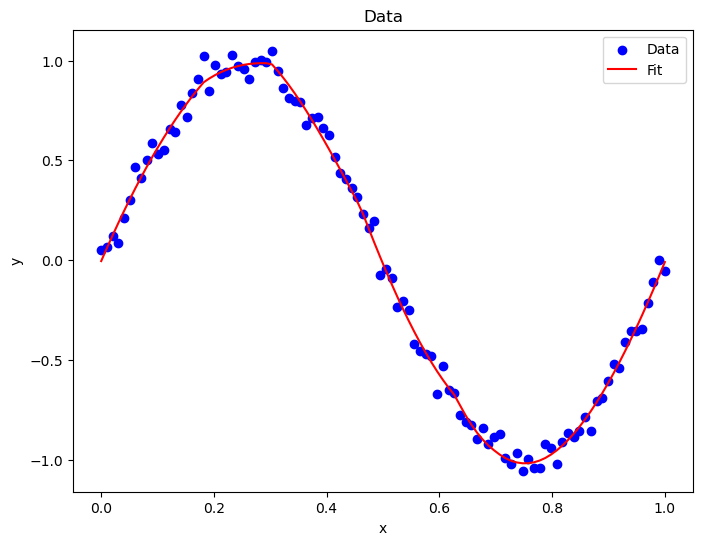

In [9]:
# plot the fit on the data
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(X, model(X_tensor).detach().numpy(), label='Fit', color='red')
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


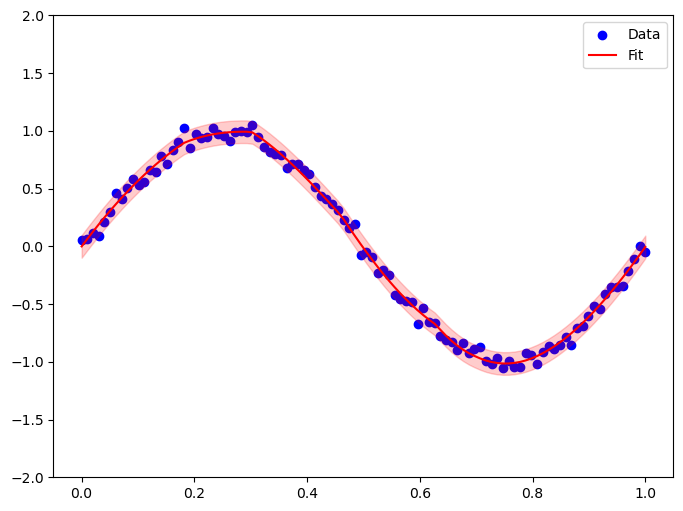

In [10]:
# Plot the MLE fit using FuncAnimation

# Create a figure and an axes
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(xlim=(-0.05, 1.05), ylim=(-2, 2))
# Plot the data
ax.scatter(X, y, label='Data', color='blue')
# Plot the initial fit
line, = ax.plot(X, fit_snapshots[0], label='Fit', color='red')
interval = ax.fill_between(X, fit_snapshots[0].squeeze() - 1.96 * np.sqrt(0.0025), fit_snapshots[0].squeeze() + 1.96 * np.sqrt(0.0025), color='red', alpha=0.2)
# Add a legend
ax.legend()

# Define an initialization function
def init():
    line.set_data(X, fit_snapshots[num_epochs-1])
    return line,

# Define an animation step function
def animate(i):
    line.set_xdata(X)
    line.set_ydata(fit_snapshots[i])
    
    # update the 95% noise variance interval
    global interval
    interval.remove()  # Remove the previous interval
    interval = ax.fill_between(X, fit_snapshots[i].squeeze() - 1.96 * np.sqrt(0.0025), fit_snapshots[i].squeeze() + 1.96 * np.sqrt(0.0025), color='red', alpha=0.2)
    return line, interval
    # return line,
    
# Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(fit_snapshots), interval=20, blit=True)

# save the animation as gif
anim.save('animation.gif', writer='Pillow', fps=30)

![Animation](./animation_fit.gif)

In [18]:
variance_values = [0.001, 0.0025, 0.005]
# List to store final fits
final_fits = []

# Train the model for each variance value
for variance_value in variance_values:
    model = nn.Sequential(
        nn.Linear(1, 10),
        nn.GELU(),
        nn.Linear(10, 10),
        nn.SELU(),
        nn.Linear(10, 1)
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = nn.MSELoss()(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    final_fits.append(model)

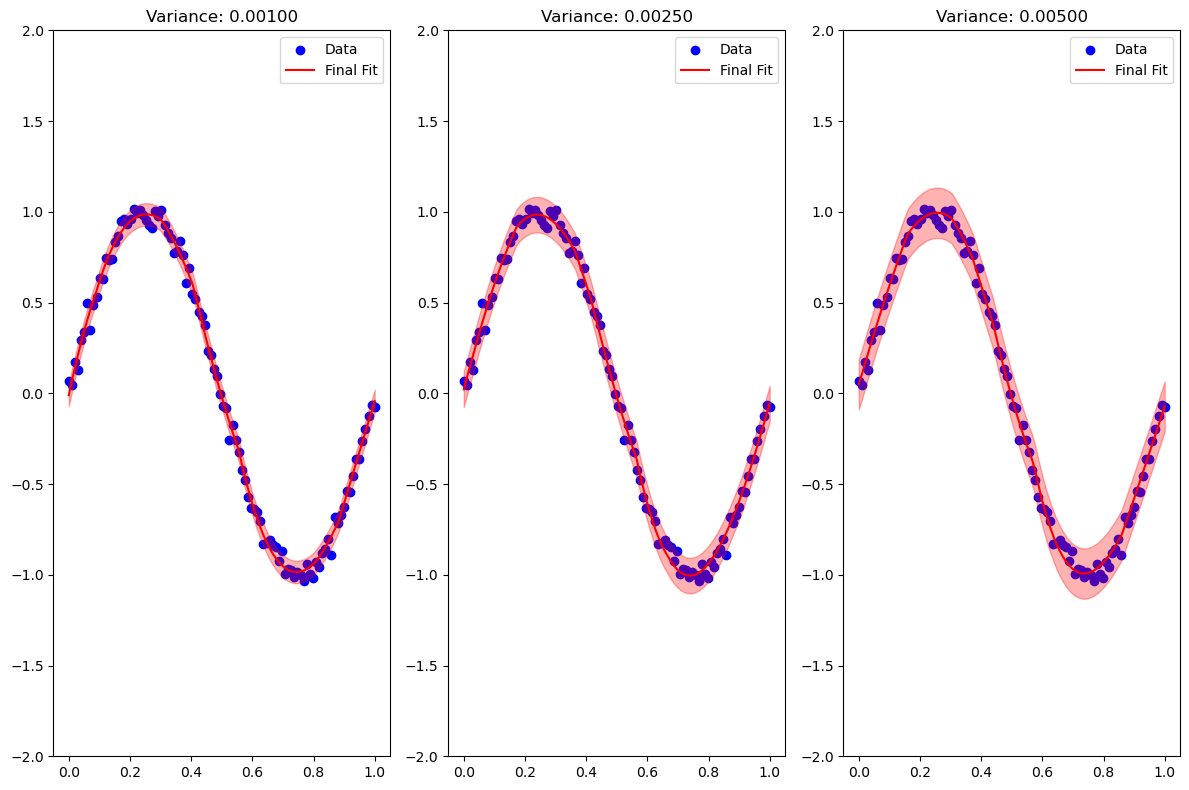

In [20]:
# Plot the final fits for each variance value
plt.figure(figsize=(12, 8))

for i, variance_value in enumerate(variance_values):
    model = final_fits[i]
    with torch.no_grad():
        predictions = model(X_tensor).detach().numpy()
    plt.subplot(1, 3, i + 1)
    plt.scatter(X, y, label='Data', color='blue')
    plt.plot(X, predictions, label='Final Fit', color='red')
    plt.fill_between(X, predictions.squeeze() - 1.96 * np.sqrt(variance_value),
                     predictions.squeeze() + 1.96 * np.sqrt(variance_value),
                     color='red', alpha=0.3)
    plt.title('Variance: {:.5f}'.format(variance_value))
    plt.legend()
    plt.ylim(-2, 2)  # Adjust based on your data range

plt.tight_layout()

### Observations

To find the MLE fit for the parameters of the neural network (weights and biases), we formed a neural network with the size according to the model summary. Our loss function is the negative log likelihood (theta), which we are trying to minimise.

Animation.gif is the gif of 1000 frames of the animation of the MLE fit (throughout the epochs) on the data along with the 95% noise variance intervals. 

We tried three different values for variance and plotted the fit. So as you can see the confidence intervals changes but the final fit remains almost same because the variance is fixed for the data. So just the loss and the change in gradient changes but the optimum point remains the same

# Question 2

You toss a coin 10 times and the result turns out to be: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0]. Find the MAP estimate for probability of heads if:
1) Prior is Beta distribution with parameters (alpha=2, beta=3):
   
    i)Calculate the answer analytically using the closed form MAP estimate [0.5 mark]
    
    ii)Find the answer with gradient descent using torch.optim [0.5 mark]
    
2) Prior is a Gaussian distribution with mean=0.5 and variance=0.1. Find the answer with gradient descent using torch.optim

### 1(i) Analytical Solution for MAP estimate for Beta distribution

theta = $\frac{n_H + α-1}{N+α+β-2}$

In [22]:
obs = torch.tensor([1,0,0,1,1,0,1,0,0,0],dtype=torch.double)
N = len(obs)
nh = obs.sum()
alpha = 2
beta = 3

In [23]:
analytical_map_beta = (nh + alpha - 1) / (N + alpha + beta - 2)

In [24]:
analytical_map_beta

tensor(0.3846, dtype=torch.float64)

### 1(ii) Gradient Descent Solution for MAP estimate for Beta distribution

In [25]:
# apply gradient descent using torch.optim to find the MAP estimate for cointoss with beta prior

def nll_coin(obs, theta):
    dist = torch.distributions.Bernoulli(theta)
    return -dist.log_prob(obs).sum()

def nll_coin_beta(theta, alpha, beta):
    dist = torch.distributions.Beta(alpha, beta)
    return -dist.log_prob(theta).sum()

def nll_coin_gaussian(theta, mu, sigma):
    dist = torch.distributions.Normal(mu, sigma)
    return -dist.log_prob(theta).sum()

In [26]:
alpha = torch.tensor(2.)
beta = torch.tensor(3.)
mode = (alpha-1)/(alpha+beta-2)
theta_initial = torch.tensor(mode, requires_grad=True)
loss_history = []
theta_history = []
optimizer = torch.optim.Adam([theta_initial], lr=0.001)

for i in range(1000):
    optimizer.zero_grad()
    loss = nll_coin_beta(theta_initial, alpha, beta) + nll_coin(obs, theta_initial)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    theta_history.append(theta_initial.item())


/var/folders/dx/m9d65spx18l9gvlny7r92xg40000gn/T/ipykernel_9070/4068050804.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_initial = torch.tensor(mode, requires_grad=True)


In [27]:
theta_initial

tensor(0.3846, requires_grad=True)

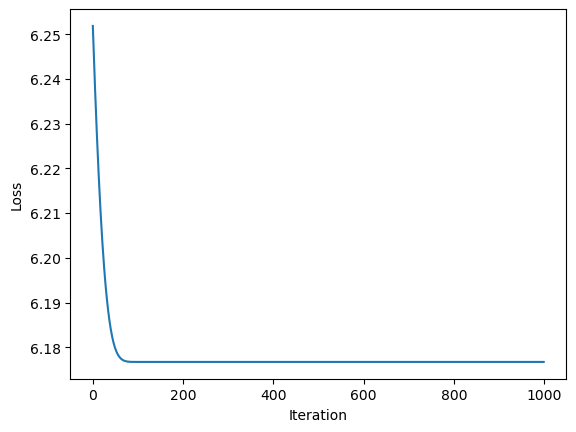

In [28]:
# plot the loss
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


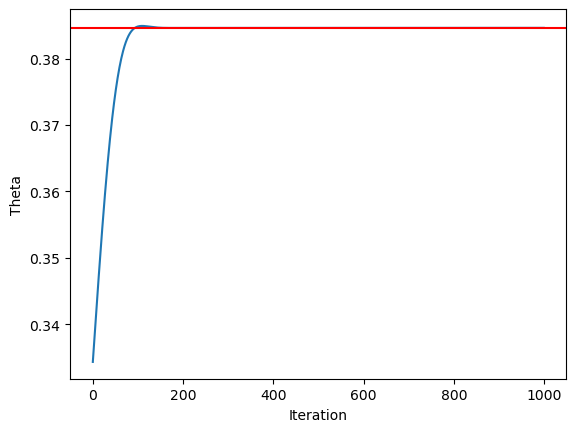

In [29]:
# plot the theta
plt.plot(theta_history)
plt.axhline(analytical_map_beta, color='r', label='Analytical Theta')
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.show()


### 2 Gradient Descent Solution for MAP estimate for Gaussian distribution

In [30]:
mu = torch.tensor(0.5)
sigma = torch.tensor(torch.sqrt(torch.tensor(0.1)))
theta_initial = torch.tensor(0.5, requires_grad=True)
loss_history = []
theta_history = []
optimizer = torch.optim.Adam([theta_initial], lr=0.001)

for i in range(1000):
    optimizer.zero_grad()
    loss = nll_coin_gaussian(theta_initial, mu, sigma) + nll_coin(obs, theta_initial)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    theta_history.append(theta_initial.item())


/var/folders/dx/m9d65spx18l9gvlny7r92xg40000gn/T/ipykernel_9070/1178223347.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(torch.sqrt(torch.tensor(0.1)))


In [31]:
theta_initial

tensor(0.4196, requires_grad=True)

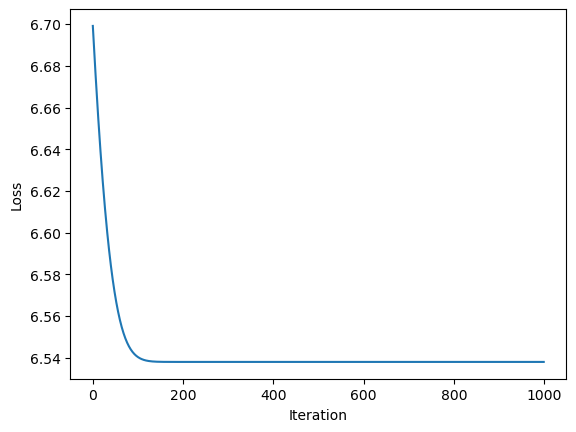

In [32]:
# plot the loss

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


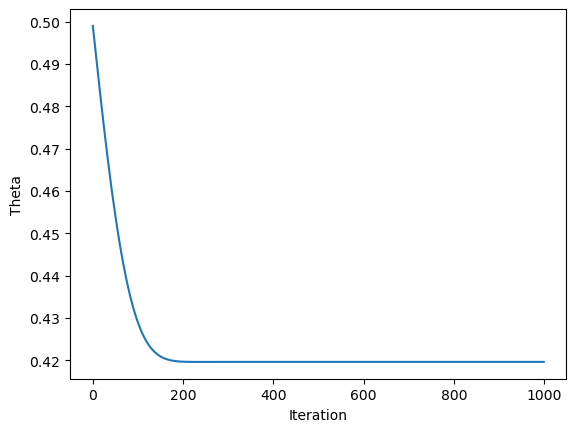

In [33]:
# plot the theta

plt.plot(theta_history)
plt.xlabel('Iteration')
plt.ylabel('Theta')
plt.show()


# Question 3

Generate a linear trend dataset with the following code (3.1). Find MAP estimate for slope and intercept:
1) Prior is Normal distribution with mean=0 and variance=1 [1 marks]
2) Show the effect of varying the size of the dataset on the MAP estimate [0.5 mark]
3) Show the effect of varying the prior variance on the MAP estimate [0.5 mark]
4) Change the prior to Laplace with mean = 0 and scale = 1. Compare the MAP estimate with the one obtained in (i). What do you observe? [0.5 mark]

In [45]:

slope = 3
intercept = 2
N = 100
X = torch.linspace(0, 1, N)
noise = torch.distributions.Normal(0, 0.05).sample((N,))
y = slope * X + intercept + noise

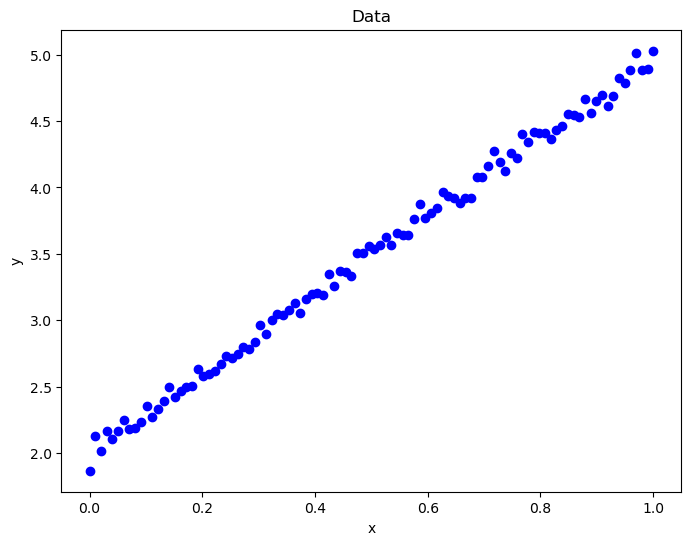

In [46]:
# data visualisation

plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### i) MAP estimate for N(0,1) prior. 

As prior for both slope, and intercept are N(0,1), so we can say that theta (parameter vector) has a prior of a bivariate normal distribution with mean (0,0) and covariance matrix as identity matrix.

In [47]:
def nll_normal_prior(theta, mu, sigma):
    dist = torch.distributions.Normal(mu, sigma)
    return -dist.log_prob(theta).sum()
def nll_laplace_prior(theta, mu, sigma):
    dist = torch.distributions.Laplace(mu, sigma)
    return -dist.log_prob(theta).sum()
def nll(theta, X, y, mu, sigma):
    deviation = y - theta[0] * X - theta[1]
    dist = torch.distributions.Normal(mu, sigma)
    return -dist.log_prob(deviation).sum()
def grad_descent(theta, X, y, prior_mean, prior_std, noise_mean, noise_std, lr, epochs, flag):
    theta0_history = []
    theta1_history = []
    loss_history = []

    for i in range(epochs):
        if(flag == 1):
            loss = nll(theta, X, y, noise_mean, noise_std) + nll_normal_prior(theta, prior_mean, prior_std)
        else:
            loss = nll(theta, X, y, noise_mean, noise_std) + nll_laplace_prior(theta, prior_mean, prior_std)
        loss_history.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
            theta.grad.zero_()
            theta0_history.append(theta[0].item())
            theta1_history.append(theta[1].item())
    return theta, theta0_history, theta1_history, loss_history

In [61]:
noise_sigma = torch.tensor(0.05)
noise_mean = torch.tensor(0.0)
initial_theta = torch.tensor([0.0,0.0],requires_grad=True)
prior_mean = torch.tensor([0.0,0.0])
prior_sigma = torch.tensor([1.0, 1.0])
learning_rate = 0.000001
epochs = 600

In [56]:
final_theta, theta0_history, theta1_history, loss_history = grad_descent(initial_theta, X, y, prior_mean, prior_sigma, noise_mean, noise_sigma, learning_rate, epochs, 1)

In [57]:
final_theta

tensor([2.9779, 2.0041], requires_grad=True)

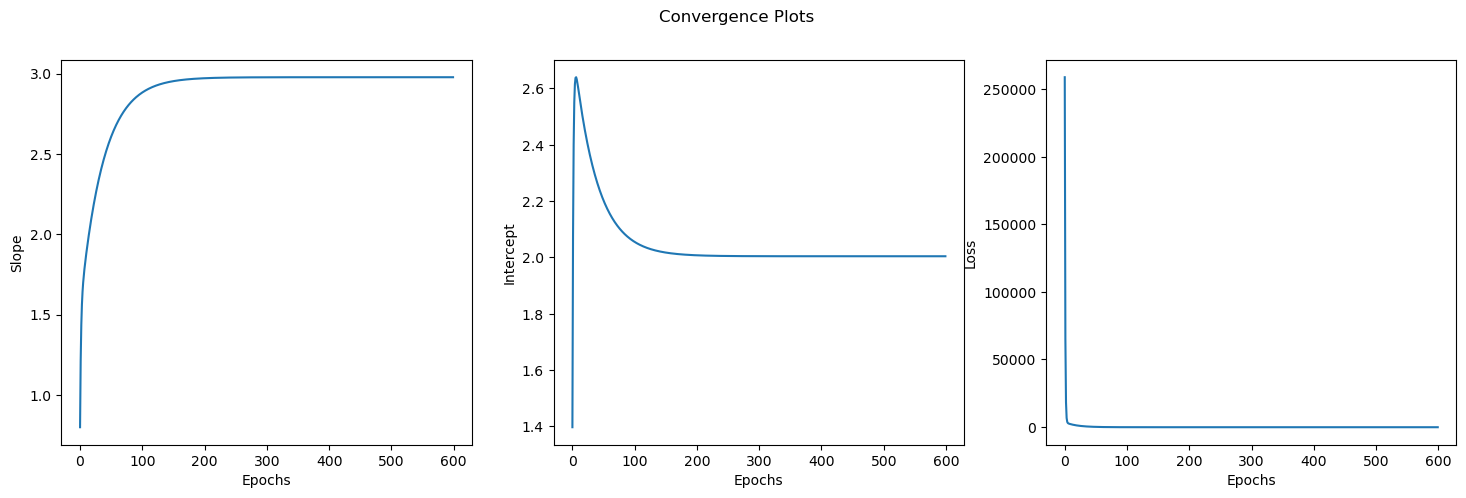

In [58]:
# convergence plots for theta0 and theta1 and loss

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
ax1.plot(theta0_history)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Slope")

ax2.plot(theta1_history)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Intercept")

ax3.plot(loss_history)
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")


fig.suptitle('Convergence Plots')
plt.show()

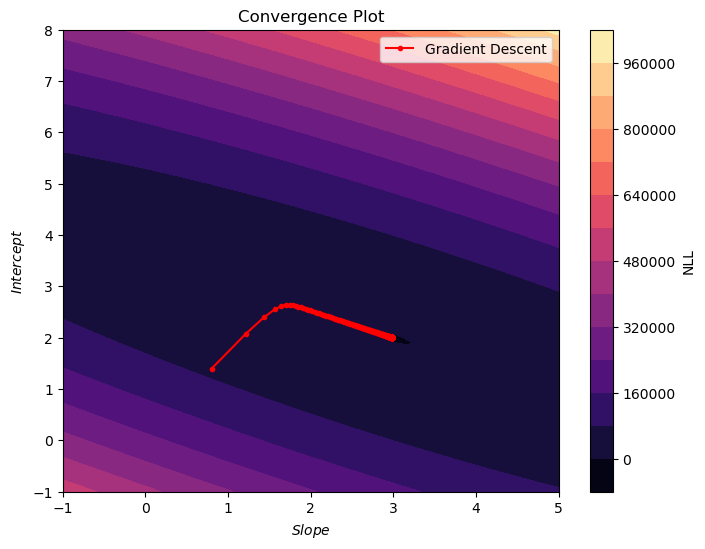

In [59]:
# contour plot

theta0_range = np.linspace(-1, 5, 100)
theta1_range = np.linspace(-1, 8, 100)

theta0_grid, theta1_grid = np.meshgrid(theta0_range, theta1_range)
loss_grid = np.zeros((100, 100))
# use for loops and fill the loss_grid
for i in range(100):
    for j in range(100):
        theta = torch.tensor([theta0_grid[i][j], theta1_grid[i][j]])
        loss_grid[i][j] = nll(theta, X, y, noise_mean, noise_sigma) + nll_normal_prior(theta, prior_mean, prior_sigma)

plt.figure(figsize=(8, 6))
contour = plt.contourf(theta0_grid, theta1_grid, loss_grid, levels=15, cmap='magma')
plt.colorbar(contour, label='NLL')
plt.plot(theta0_history, theta1_history, marker='o', markersize=3, color='r', label='Gradient Descent')
plt.xlabel('$Slope$')
plt.ylabel('$Intercept$')
plt.title('Convergence Plot')
plt.legend()
plt.show()

### ii) Effect of varying the size of the dataset on the MAP estimate

In [62]:
dataset_sizes = [5, 10, 20, 50, 100, 500, 800, 1000]
log_sizes = np.round(np.log2(dataset_sizes)).astype(int)
theta0_sizes = []
theta1_sizes = []
true_theta = torch.tensor([slope, intercept])

for size in dataset_sizes:
    X = torch.linspace(0, 1, size)
    noise = torch.distributions.Normal(0, 0.05).sample((size,))
    y = slope * X + intercept + noise
    final_theta, theta0_history, theta1_history, loss_history = grad_descent(initial_theta, X, y, prior_mean, prior_sigma, noise_mean, noise_sigma, learning_rate, epochs, 1)
    theta0_sizes.append(final_theta[0].item())
    theta1_sizes.append(final_theta[1].item())

  

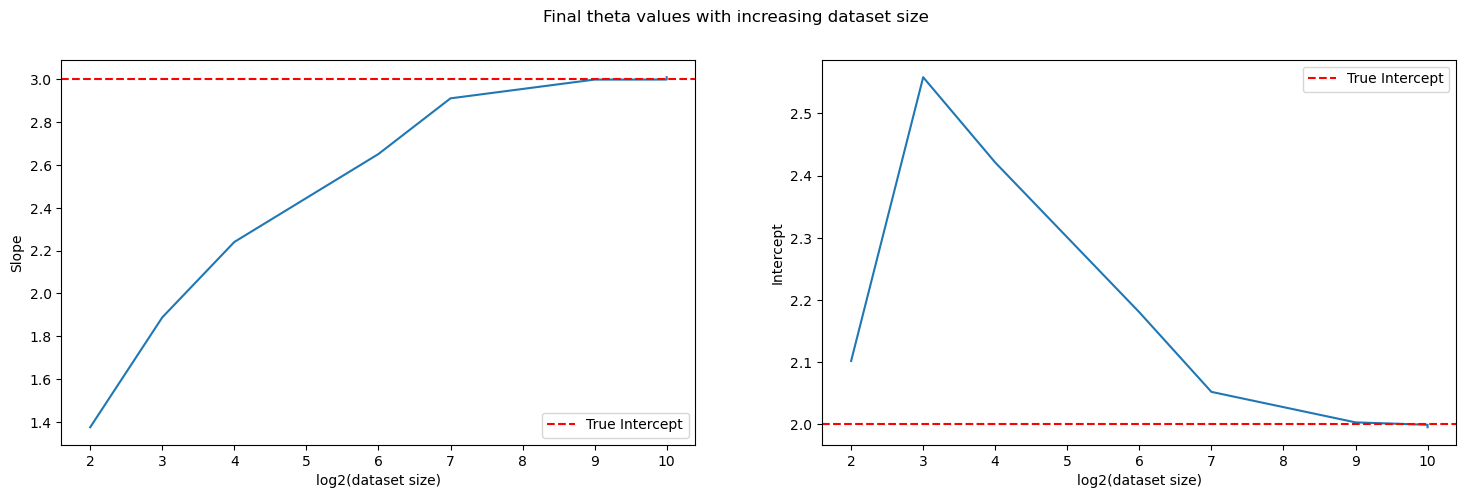

In [63]:
# convergence plots for theta0 and theta1 with increasing dataset size

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.plot(log_sizes, theta0_sizes)
ax1.set_xlabel("log2(dataset size)")
ax1.set_ylabel("Slope")
ax1.axhline(true_theta[0], color='red', linestyle='--', label='True Intercept')
ax1.legend()

ax2.plot(log_sizes, theta1_sizes)
ax2.set_xlabel("log2(dataset size)")
ax2.set_ylabel("Intercept")
ax2.axhline(true_theta[1], color='red', linestyle='--', label='True Intercept')
ax2.legend()

fig.suptitle('Final theta values with increasing dataset size')
plt.show()

### iii) Effect of varying the prior variance on the MAP estimate

In [86]:
slope = 3
intercept = 2
N = 100
X = torch.linspace(0, 1, N)
noise = torch.distributions.Normal(0, 0.05).sample((N,))
y = slope * X + intercept + noise

In [87]:
noise_sigma = torch.tensor(0.05)
noise_mean = torch.tensor(0.0)
initial_theta = torch.tensor([0.0,0.0],requires_grad=True)
prior_mean = torch.tensor([0.0,0.0])
prior_sigma = torch.tensor([1.0, 1.0])
learning_rate = 0.000001
epochs = 300

In [88]:
theta0_std = []
theta1_std = []
prior_sigma_values = [0.1, 0.5, 1.0, 2.0, 2.5, 5.0, 10.0, 12.5]

for prior_sigma_i in prior_sigma_values:
    prior_sigma_new = torch.tensor([prior_sigma_i, prior_sigma_i])
    final_theta, theta0_history, theta1_history, loss_history = grad_descent(initial_theta, X, y, prior_mean, prior_sigma_new, noise_mean, noise_sigma, learning_rate, epochs, 1)
    theta0_std.append(final_theta[0].item())
    theta1_std.append(final_theta[1].item())

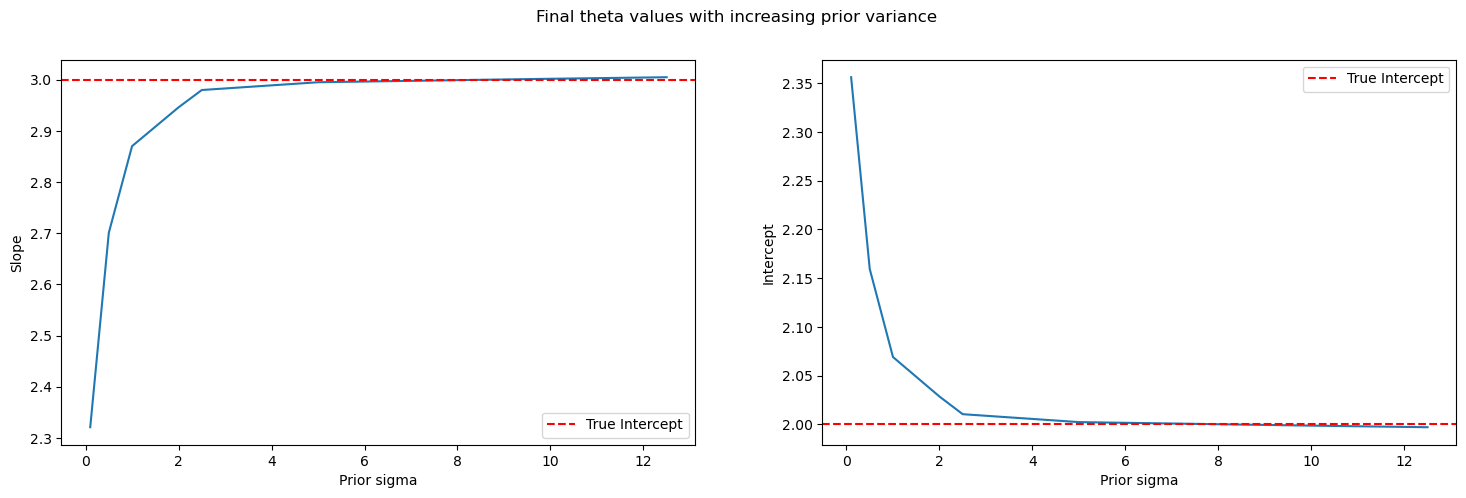

In [89]:
# convergence plots for theta0 and theta1 with increasing prior sigma
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.plot(prior_sigma_values, theta0_std)
ax1.set_xlabel("Prior sigma")
ax1.set_ylabel("Slope")
ax1.axhline(true_theta[0], color='red', linestyle='--', label='True Intercept')
ax1.legend()

ax2.plot(prior_sigma_values, theta1_std)
ax2.set_xlabel("Prior sigma")
ax2.set_ylabel("Intercept")
ax2.axhline(true_theta[1], color='red', linestyle='--', label='True Intercept')
ax2.legend()

fig.suptitle('Final theta values with increasing prior variance')
plt.show()

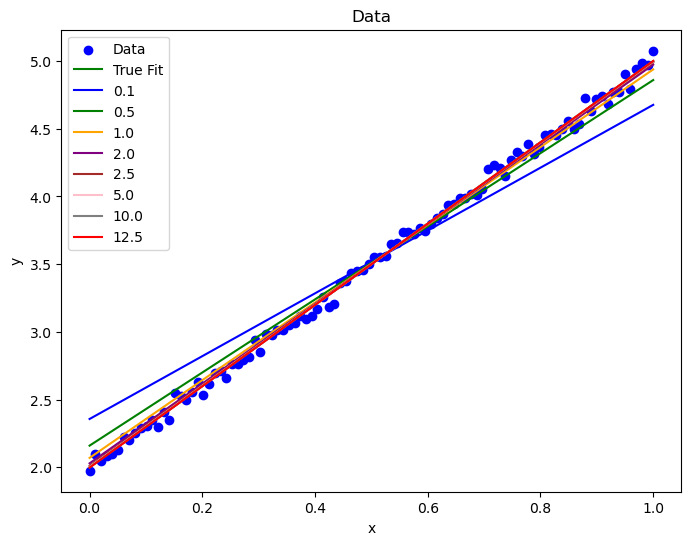

In [97]:
# plot the fit on the data for different prior sigma
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'red']
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(X, slope * X + intercept, label='True Fit', color='green')
for i in range(8):
    plt.plot(X, theta0_std[i] * X + theta1_std[i], label=prior_sigma_values[i], color=colors[i])
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



### Observation

As we increase the variance of the prior, the MAP estimate moves towards the MLE estimate. This is because the prior is less informative and the likelihood dominates the posterior.

This can be seen as the ridge penalty, where on increasing variance, the model focuses more on data rather than the magnitude of the parameters. This is why on increasing the variance, the model starts to overfit.


### iv) Change the prior to Laplace with mean = 0 and scale = 1. Compare the MAP estimate with the one obtained in (i). What do you observe?

In [67]:
slope = 3
intercept = 2
N = 100
X = torch.linspace(0, 1, N)
noise = torch.distributions.Normal(0, 0.05).sample((N,))
y = slope * X + intercept + noise

In [68]:
noise_sigma = torch.tensor(0.05)
noise_mean = torch.tensor(0.0)
initial_theta = torch.tensor([0.0,0.0],requires_grad=True)
prior_mean = torch.tensor([0.0,0.0])
prior_sigma = torch.tensor([1.0, 1.0])
learning_rate = 0.00001
epochs = 1000

In [69]:
final_theta, theta0_history, theta1_history, loss_history = grad_descent(initial_theta, X, y, prior_mean, prior_sigma, noise_mean, noise_sigma, learning_rate, epochs, 0)

In [70]:
final_theta

tensor([3.0341, 1.9889], requires_grad=True)

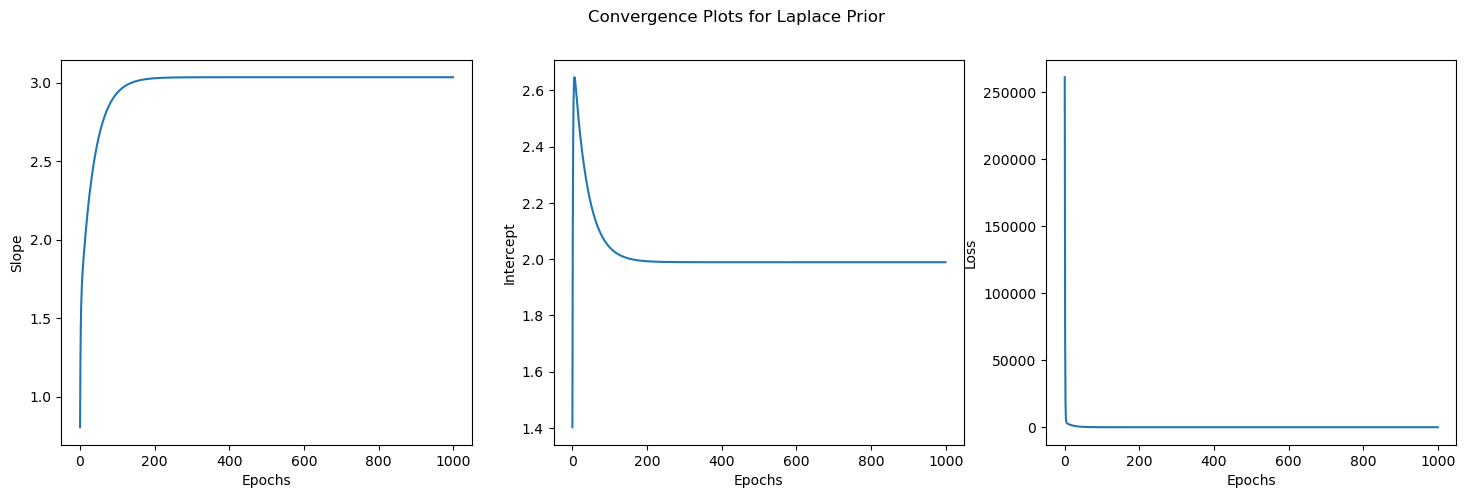

In [71]:
# convergence plots for theta0 and theta1 and loss

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
ax1.plot(theta0_history)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Slope")

ax2.plot(theta1_history)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Intercept")

ax3.plot(loss_history)
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")


fig.suptitle('Convergence Plots for Laplace Prior')
plt.show()

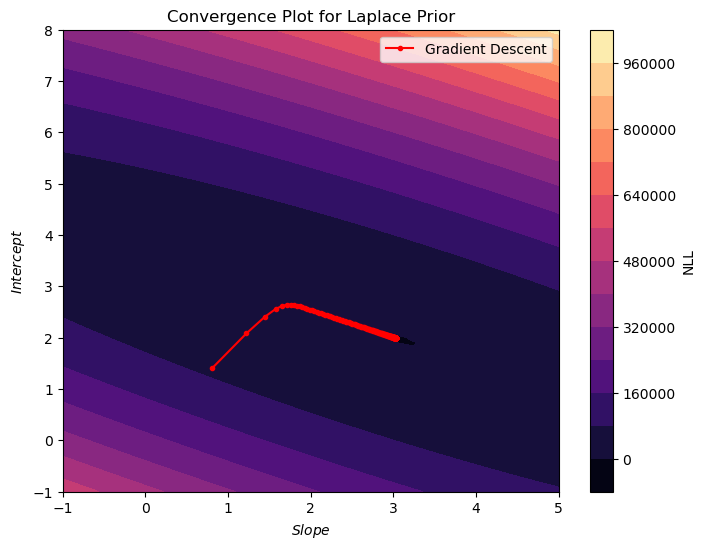

In [72]:
# contour plot

theta0_range = np.linspace(-1, 5, 100)
theta1_range = np.linspace(-1, 8, 100)

theta0_grid, theta1_grid = np.meshgrid(theta0_range, theta1_range)
loss_grid = np.zeros((100, 100))
# use for loops and fill the loss_grid
for i in range(100):
    for j in range(100):
        theta = torch.tensor([theta0_grid[i][j], theta1_grid[i][j]])
        loss_grid[i][j] = nll(theta, X, y, noise_mean, noise_sigma) + nll_laplace_prior(theta, prior_mean, prior_sigma)

plt.figure(figsize=(8, 6))
contour = plt.contourf(theta0_grid, theta1_grid, loss_grid, levels=15, cmap='magma')
plt.colorbar(contour, label='NLL')
plt.plot(theta0_history, theta1_history, marker='o', markersize=3, color='r', label='Gradient Descent')
plt.xlabel('$Slope$')
plt.ylabel('$Intercept$')
plt.title('Convergence Plot for Laplace Prior')
plt.legend()
plt.show()

### Observations

# Question 4

 Generate a classification dataset with the following code (4.1). Find the MAP estimate for the parameters of logistic regression. Assume Normal prior with mean=0 and variance=0.1 for all parameters. Visualize the MLE and MAP classification boundaries. What do you observe? 

In [98]:
X, y = make_blobs(
    n_samples=100, centers=2, n_features=2, random_state=0, cluster_std=0.8
)

In [99]:
X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.double)

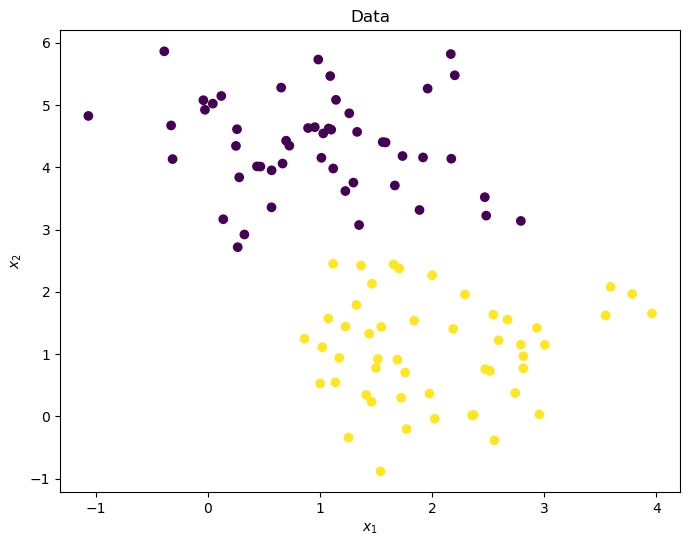

In [100]:
# visualize the data

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Data')
plt.show()

As there are 2 features, so we can say that theta (parameter vector) has a prior of a trivariate normal distribution with mean (0,0,0) and covariance matrix as 0.1 times identity matrix.

In [36]:
def nll_logistic(theta, X, y):
    logits = theta[0] + theta[1] * X[:, 0] + theta[2] * X[:, 1]
    dist = torch.distributions.Bernoulli(logits=logits)
    return -dist.log_prob(y).sum()

def nll_normal_prior_logistic(theta, prior_mean, prior_sigma):
    dist = torch.distributions.Normal(prior_mean, prior_sigma)
    return -dist.log_prob(theta).sum()

def grad_descent_logistic(theta, X, y, prior_mean, prior_std, lr, epochs, flag):
    theta0_history = []
    theta1_history = []
    theta2_history = []
    loss_history = []

    for i in range(epochs):
        if(flag == 1):
            loss = nll_logistic(theta, X, y) + nll_normal_prior_logistic(theta, prior_mean, prior_std)
        else:
            loss = nll_logistic(theta, X, y)
        loss_history.append(loss.item())
        theta0_history.append(theta[0].item())
        theta1_history.append(theta[1].item())
        theta2_history.append(theta[2].item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
            theta.grad.zero_()
    return theta, theta0_history, theta1_history, theta2_history, loss_history



In [37]:
initial_theta = torch.tensor([0.0,0.0,0.0],requires_grad=True)
prior_mean = torch.tensor([0.0,0.0,0.0])
std = torch.sqrt(torch.tensor(0.1))
prior_sigma = torch.tensor([std,std,std])
learning_rate = 0.01
epochs = 2000
isMap = 0


### MLE Estimate for Logistic Regression

In [40]:
final_theta_mle, theta0_history, theta1_history, theta2_history, loss_history_mle = grad_descent_logistic(initial_theta, X, y, prior_mean, prior_sigma, learning_rate, epochs, isMap)

In [41]:
final_theta_mle

tensor([11.8304,  1.2180, -5.1210], requires_grad=True)

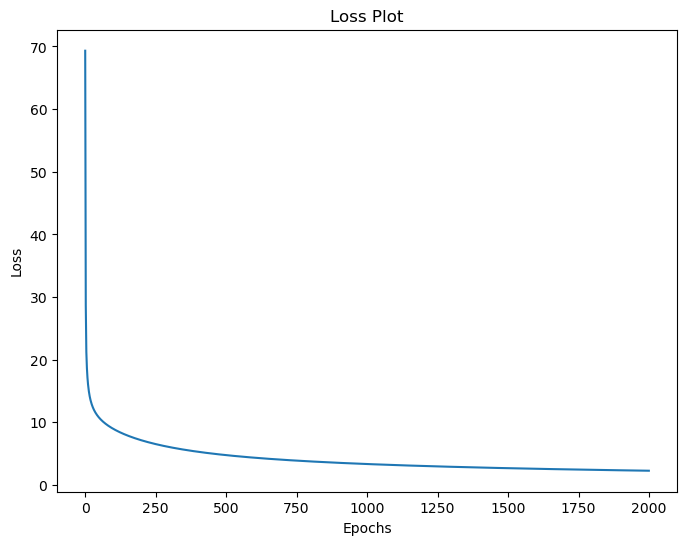

In [42]:
# plot the loss

plt.figure(figsize=(8, 6))
plt.plot(loss_history_mle)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


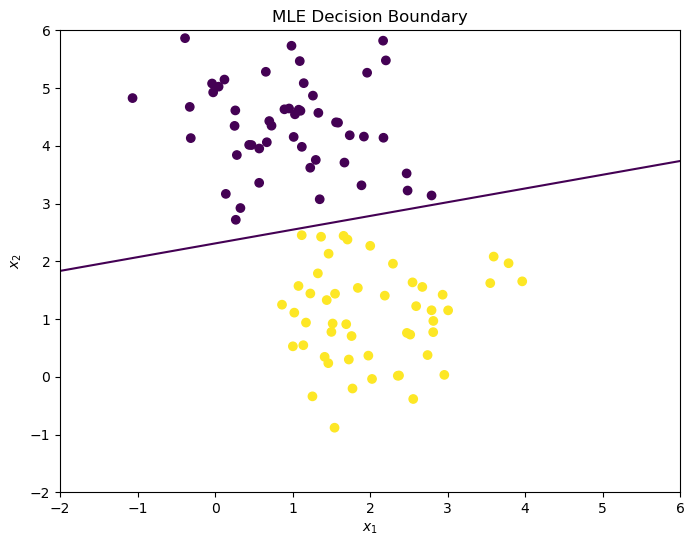

In [14]:
# plot the decision boundary for MLE estimate

x1 = np.linspace(-2, 6, 100)
x2 = np.linspace(-2, 6, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
logits_grid = final_theta_mle[0].item() + final_theta_mle[1].item() * x1_grid + final_theta_mle[2].item() * x2_grid
prob_grid = 1 / (1 + np.exp(-logits_grid))

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.contour(x1_grid, x2_grid, prob_grid, levels=[0.5])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('MLE Decision Boundary')
plt.show()


### MAP estimate for Logistic Regression

In [50]:
initial_theta = torch.tensor([0.0,0.0,0.0],requires_grad=True)
prior_mean = torch.tensor([0.0,0.0,0.0])
std = torch.sqrt(torch.tensor(0.1))
prior_sigma = torch.tensor([std,std,std])
learning_rate = 0.001
epochs = 1500
isMap = 1

In [51]:
final_theta_map, theta0_history, theta1_history, theta2_history, loss_history_map = grad_descent_logistic(initial_theta, X, y, prior_mean, prior_sigma, learning_rate, epochs, isMap)

In [52]:
final_theta_map

tensor([ 0.4892,  0.9147, -0.8464], requires_grad=True)

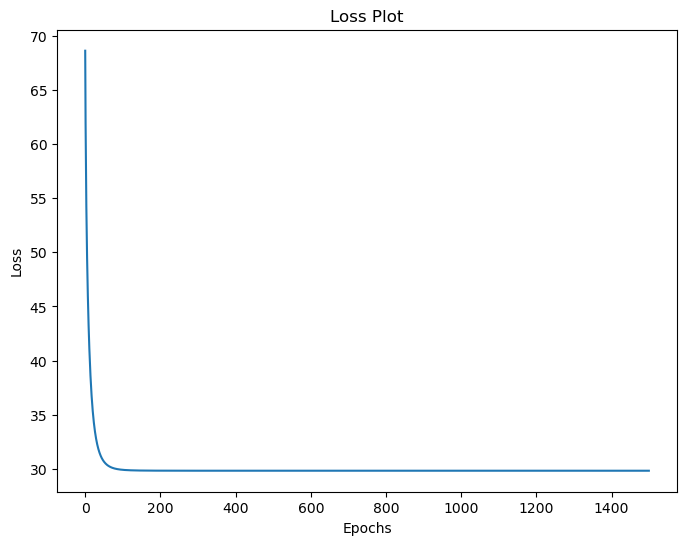

In [53]:
# plot the loss

plt.figure(figsize=(8, 6))
plt.plot(loss_history_map)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


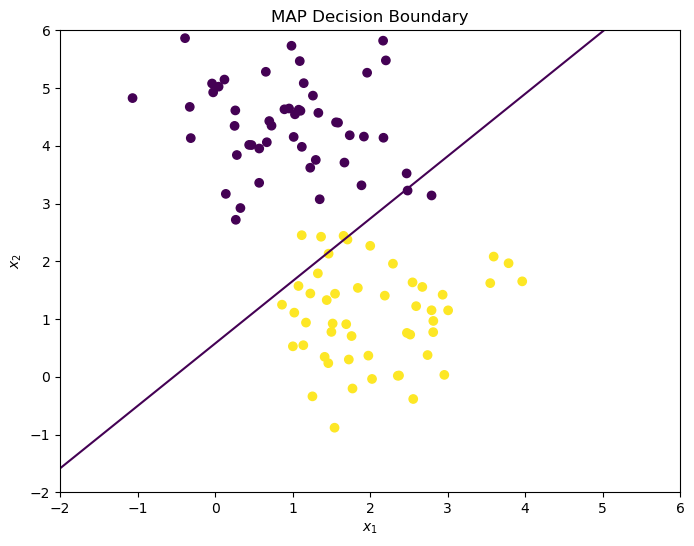

In [54]:
# plot the decision boundary for MAP estimate

x1 = np.linspace(-2, 6, 100)
x2 = np.linspace(-2, 6, 100)
x1_grid, x2_grid = np.meshgrid(x1, x2)
logits_grid = final_theta_map[0].item() + final_theta_map[1].item() * x1_grid + final_theta_map[2].item() * x2_grid
prob_grid = 1 / (1 + np.exp(-logits_grid))

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.contour(x1_grid, x2_grid, prob_grid, levels=[0.5])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('MAP Decision Boundary')
plt.show()


### Observations